# NAND* programming languages specification

_Version: 0.5_

The NAND-CIRC, NAND-TM, and NAND-RAM programming languages were designed to accompany the upcoming book ["Introduction to Theoretical Computer Science"](http://introtcs.org). This is an appendix to this book, which is also available online as a Jupyter notebook in the  [boazbk/tcscode](https://github.com/boazbk/tcscode) on Github. 

The book is not a programming book, and readers can follow along without ever looking at the specifications of these programming languages. Still, for the sake of completeness, we provide these here.

We use the following main models of computation in this book:

####  <font color='blue'>Computing __finite__ functions with __nonuniform__ algorithms:</font>

__Boolean Circuits__ and __NAND-CIRC__ straightline programs. We also use other variants that correspond to different gate sets.  These models are presented in [Chapter 3: Defining Computatoin](https://introtcs.org/public/lec_03_computation.html).

#### <font color='blue'>Computing __unbounded input length__ functions with __uniform__ algorithms:</font>

We have two main models, depending on the memory access. __Turing Machines__ have __sequential access__ to memory, and the programming language equivalent is __NAND-TM__. They are defined in [Chapter 6: Loops and infinity](https://introtcs.org/public/lec_06_loops.html). __RAM Machines__ have __random access__ (aka __indexed access__ or __indirect addressing__) to memory, and their programming language equivalent is __NAND-RAM__. They are defined in [Chapter 7: Equivalent models of computation](https://introtcs.org/public/lec_07_other_models.html). 

# The NAND-CIRC Programming Language

A NAND-CIRC program is a sequence of lines. Every line in NAND-CIRC has the form 

`<varid> = NAND(<varid>,<varid>)`

where `varid` (standing for _variable identifier_) is a sequence of letters, numbers,  underscores, and brackets (`[`,`]`). Only variables of the form `X[<num>]` and `Y[<num>]` can contain brackets. Moreover, all other variables identifiers must begin with a lowercase letter. 

Variables of the form `X[<num>]` for a number `<num>` are _input variables_, and variables of the form `Y[<num>]` are _output variables_. 

For every valid NAND-CIRC program $P$, there must be some integers $n,m>0$ such that the input and output variables are  `X[0]` ... `X[`$n-1$`]` for some $n>0$ and `Y[0]` ... `Y[`$m-1$`]` for some $m>0$ and all of those appear in the program. (For example, if a program contains the variable `X[3]` then it must also contain `X[2]`,`X[1]`  and `X[0]`.

An input variable can not appear on the lefthand side of the assignment operation `foo = NAND(bar,blah)`, and an output variable cannot appear on the righthand side of it.

__Evaluating a NAND-CIRC program:__ If $P$ is a NAND-CIRC program with $n$ inputs and $m$ outputs, and $x\in \{0,1\}^n$, then the _output of $P$ on input $x$_, denoted by $P(x)$, is defined as the string $y\in \{0,1\}^m$ which is the result of the following process:

1. We initialize the variables `X[0]` ... `X[`$n-1$`]` to $x_0,\ldots,x_{n-1}$ and all other variables to $0$.

2. We run the program line by line, where a line of the form `foo = NAND(bar,blah)` is evaluated by assigning to the variable `foo` the NAND of the values of the variables `bar` and `blah`

3. At the end of the execution, output the values of the variables `Y[0]` ... `Y[`$m-1$`]`

### A Python implementation of NAND-CIRC evaluation:

In [5]:
def parseline(line, numargs = 0):
    """Parse a line of the form foo = 'OP( bar1, bar2, bar3)'
       to ['foo','OP','bar1','bar2','bar2'].
       If numargs > number of arguments in line then add empty strings to the list as needed."""
    i = line.find("=")
    j = line.find("(")
    k = line.find(")")
    if i<0 or j<0 or k<0: raise Exception(f"Line not formatted properly: {line}")
    args = [a.strip() for a in line[j+1:k].split(",")]
    if len(args)<numargs: args += [""]*(numargs-len(args))
    return [line[:i].strip() , line[i+1:j].strip()] + args
        

In [6]:
import re
def numinout(prog):
    '''Compute the number of inputs and outputs of a NAND program, given as a string of source code.'''
    n = max([int(s[2:-1]) for s in re.findall(r'X\[\d+\]',prog)])+1
    m = max([int(s[2:-1]) for s in re.findall(r'Y\[\d+\]',prog)])+1
    return n,m

In [11]:
def EVAL(code,X):
    """Evaluate code on input X."""
    n,m = numinout(code) # helper function - get number of inputs and outputs
    vtable = { f"X[{i}]":int(X[i]) for i in range(n)}
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line) 
        vtable[foo] =  1-vtable[bar]*vtable[blah]
    
    return [vtable[f"Y[{j}]"] for j in range(m)]            

In [14]:
code = r'''temp_1 = NAND(X[0],X[1])
temp_2 = NAND(X[0],temp_1)
temp_3 = NAND(X[1],temp_1)
temp_4 = NAND(temp_2,temp_3)
temp_5 = NAND(temp_4,X[2])
temp_6 = NAND(temp_4,temp_5)
temp_7 = NAND(X[2],temp_5)
Y[0] = NAND(temp_6,temp_7)
'''
EVAL(code,"011")

[0]

### NAND-CIRC and Boolean Circuits 

NAND-CIRC is of course equivalent to Boolean circuits

In [1]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

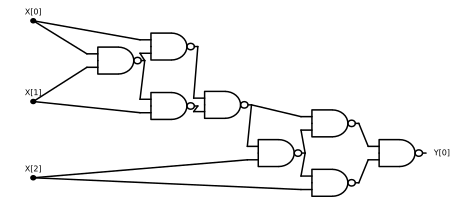

In [16]:
circuit(code)

# The NAND-TM Programming Language

Just like NAND-CIRC models circuits, NAND-TM models _Turing Machines_. NAND-TM introduces an index variable `i` that is initialized to $0$ and allows to index _arrays_.

A NAND-TM program is a sequence of lines. Every line in NAND-TM except the last one has the form 

`<varid> = NAND(<varid>,<varid>)`

where `varid` (standing for _variable identifier_) is a sequence of letters, numbers,  underscores, and brackets (`[`,`]`). Only variable identifiers starting with uppercase letters can contain brackets. If `<varid>` starts with an uppercase letter it must be of the form `<Name>[<idx>]` where `<Name>` is a sequence of letters, numbers, and underscores starting with an uppercase letter, and `<idx>` is either a sequence of numbers or the letter `i`.
(for example `Bar[354]` or `Foo[i]`).

Variables whose identifiers start with uppercase letters are known as _array variables_ and variables whose identifiers start with lowercase letters are known as _scalar variables_.

Variables of the form `X[<idx>]`  are _input variables_, and variables of the form `Y[<idx>]` are _output variables_. 

The last line of a NAND-TM program has the form `MODANDJMP(<varid>,<varid>)`

### Execution of a NAND-TM program

to be completed

### Python implementation of NAND-TM

to be completed

## The NAND-RAM programming language

The NAND-RAM programming language allows _indirection_, hence using variables  as  _pointer_ or _index_ variables.
Unlike the case of NAND-TM vs NAND-CIRC, NAND-RAM cannot compute functions that NAND-TM can not (and indeed any NAND-RAM program can be "compiled" to a NAND-TM program) but it can be polynomially faster.

The main features of NAND-RAM are the following:

* Variables can hold values that are _arbitrary non negative integers_, rather than just zero or one.

* We use the convention that a variable whose name starts with a capital letter is an _array_ and a variable whose name starts with a lowercase letter is a _scalar_ variable.

* If `Foo` is an array and `bar` is a scalar, then `Foo[bar]` denotes the integer stored in the `bar`-th location of the array `Foo`

### NAND-RAM operations

Unlike our previous programming languages, NAND-RAM is not as minimalistic and contains a larger number of operations, many of which are redundant, in the sense that they can be implemented using other operations. The one component NAND-RAM does _not_ contain (though it can be of course implemented as syntatic sugar) is function calls.  This is because we want to maintain the invariant that an execution of a single line of NAND-RAM corresponds to a single computational step.


The NAND-RAM programming language allows the following operations:

* `foo = bar` (assignment)
* `foo = bar  + baz` (addition)
* `foo = bar - baz` (subtraction)
* `foo = bar >> baz` (right shift: $foo \leftarrow \lfloor bar 2^{-baz} \rfloor$)
* `foo = bar << baz` (left shift: $foo \leftarrow bar 2^{baz}$)
* `foo = bar % baz`  (modular reduction)
* `foo = bar * baz` (multiplication)
* `foo = bar / baz` (integer division: $foo \leftarrow \lfloor \tfrac{bar}{baz} \rfloor$)
* `foo = BITAND(bar,baz)` (bitwise AND)
* `foo = BITXOR(bar,baz)` (bitwise XOR)
* `foo = bar > baz` (greater than)
* `foo = bar < baz` (smaller than)
* `foo = EQUAL(bar,baz)` (equality)
* `foo = BOOL(bar)` (booleanize: `foo` gets $0$ if bar equals $0$ and gets $1$ otherwise)

We also use the following Boolean opertions (which apply `BOOL` implicitly to their input):

* `foo = NAND(bar,baz)`
* `foo = OR(bar,baz)`
* `foo = AND(bar,baz)`
* `foo = NOT(bar)`

In each one of the above `foo` , `bar` and `baz` denotes variables that are either of the form `scalarvar` or `Arrayvar[scalarvar]` or `Arrayvar[num]` (that is either a scalar variable or an array variable at a location indexed by a scalar variable or a numerical value).

We also have the following __control flow__ operations:

* `if foo: ...code... endif` performs `...code...` (which is a sequence of lines that starts with a newline) if  `foo` is nonzero.

* `while foo: ...code... endwhile` performs `...code...` as long as `foo` is nonzero.

* `do: ...code... until foo` performs `...code...` and if `foo` is zero then it goes back and does it again until `foo` becomes nonzero.



__Invariant:__ Each scalar variable or an element of an array variable in NAND-RAM can only hold an integer that ranges between $0$ and $t+1$ where $t$ is the number of lines of code (that is computational steps) that have been executed so far.  Another way to think about it as that we initialize $t=1$ in the beginning of the execution, and every time we execute a line of code, we increment $t$ by one. 

__Overflow and underflow:__ In all the operatoins above, they would have resulted in assigning a value to `foo` that is smaller than zero, then we assign zero instead. If they would have resulted in assigning a value to `foo` that is larger than $t+1$, then we assign $t+1$ instead. Note that one can ensure that the latter case does not happen by prefacing the operation with a loop that runs for at least $T$ times, where $T$ is an uppper bound on the value that we'll need. For this reason, this overflow restriction is immaterial when discussing issues of _computability_ and only makes a difference when one want to measure _running time_.

__Zero default:__ Just like NAND-CIRC and NAND-TM  all variables that have not been assigned a value are assigned zero.

__Definition:__ For a NAND-RAM program $P$ and input $x\in \{0,1\}^*$, the _time_ that $P$ takes on input $x$ is defined as the number of NAND-RAM lines that are executed if $P$ is initialized with $x$ until it halts.

### Execution of a NAND-RAM program

to be completed

### Python implementation of NAND-RAM

to be completed

## NAND-RAM to NAND-TM compiler

To be completed